In [1]:
import re
import os
import sys
import csv
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from Bio import SeqIO, pairwise2, AlignIO
from collections import Counter, namedtuple
from Bio.Align import AlignInfo, MultipleSeqAlignment
import importlib
# importlib.reload(sys.modules['MultipleCutter'])
from Sequence import Sequence
from Util.SeqUtil import seqInfo, parseFasta
from Evaluation.DfamEvaluation import DfamEvaluation
from DataStructure import refSeqSimilarityInfo
from SharedInfo import currDatasetName, cutterA, cutterB, colorA, colorB
from Util.AnalysisUtil import listToSortedCounter, getStatisticData, mostCommonTable
from Util.PlotUtil import basicPlot, twoLabelBasicPlot, lengthScatterDistributionPlot
from MultipleCutter import MultipleCutter

In [2]:
seqA = Sequence(cutterA)
parseFastaA = seqA.parseFasta()
fragmentLenListA, fragmentSeqListA = seqA.parseSeqByCutter()
repeatInfoListA = seqA.findRepeatSeqs(lengthLimit=False)
filterRepeatInfoA = seqA.filterRepeatInfo()
repeatPositionListA = seqA.getRepeatPositionList(filter=True)
seqAState = seqA.seqStateGenerator()

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.16644668579101562 sec to parse fasta file ...
...start parse seq by cutter: GATC
...cost 0.8931179046630859 sec to cut sequence
... start finding repeat seq ...
...cost0.12377595901489258 sec to finding repeat seq  ...


In [3]:
seqB = Sequence(cutterB)
parseFastaB = seqB.parseFasta()
fragmentLenListB, fragmentSeqListB = seqB.parseSeqByCutter()
repeatInfoListB = seqB.findRepeatSeqs(lengthLimit=False)
filterRepeatInfoB = seqB.filterRepeatInfo()
repeatPositionListB = seqB.getRepeatPositionList(filter=True)
seqBState = seqB.seqStateGenerator()

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.13684797286987305 sec to parse fasta file ...
...start parse seq by cutter: AAGCTT
...cost 0.8320341110229492 sec to cut sequence
... start finding repeat seq ...
...cost0.0067670345306396484 sec to finding repeat seq  ...


In [4]:
seqInfo(currDatasetName, parseFastaA)

dm6/chrX_sequence dataset
 number of sequence:1
 total length:23542271



In [5]:
# repeatPositionList = repeatPositionListA + repeatPositionListB

In [6]:
# print(f'Check cutter A, B: \n {len(repeatPositionList)} = {len(repeatPositionListA)} + {len(repeatPositionListB)}')

In [7]:
# repeatPositionList[0]

In [8]:
# df = pd.DataFrame(columns=['startIdx', 'endIdx', 'length'])
# for i in repeatPositionList:
#     df = df.append({'startIdx': i.startIdx, 'endIdx': i.endIdx, 'length': i.endIdx-i.startIdx}, ignore_index=True)
# df.to_csv(f'../outputFile/PartialSeqInfo/NonFilter_Position.csv')

In [9]:
# repeat position
multipleCutter = MultipleCutter(chrLength=len(parseFastaA[0]), seqStateList = [seqAState, seqBState])
seqStateSum = multipleCutter.getSeqStateSum()
unMatchState, unionState, intersectionState = multipleCutter.getSeqStateInfo()
stateName="intersection"
matchStateIdxList = multipleCutter.getSpecificStateIdxList(stateName)
matchStatePositionList = multipleCutter.getSpecificStatePositionList()

chr: 23542271
unMatch: 22650092, union:892179, intersection:120803


In [31]:
# # [ Output GroupByData File ]
# df = pd.DataFrame(columns=["length", "startIdx", "endIdx", "seq"])
# for i in matchStatePositionList:
#     df = df.append({"length": i.length, "startIdx": i.startIdx, "endIdx": i.endIdx, "seq": parseFastaA[0][i.startIdx:i.endIdx]}, ignore_index=True)

# matchDfGroupByLen = df.groupby(by=["length"], sort=True)
# tem = df.groupby(by=["length"]).agg({"length": "sum"})

# original_stdout = sys.stdout
# with open(f'../outputFile/SeqState/groupByLenData_{stateName}.txt', 'w') as f:
#     sys.stdout = f
#     for key, row in tem.iterrows():
#         print(f"{key}:")
#         for i in matchDfGroupByLen.get_group(key).index:
#             print(f"({ df.iloc[i]['startIdx']}, {df.iloc[i]['endIdx']})\n{ df.iloc[i]['seq']}")
#         print("\n")
#     sys.stdout = original_stdout

In [63]:
# [ Output SeqState File ]
# multipleCutter.generateSeqStateSumFile(filePath = '../outputFile/SeqState/seqStateSum.txt')

In [64]:
# intersection , union
# unionMatchStateIdxList = multipleCutter.getSpecificStateIdxList("union")
# len(matchStatePositionList), len(unionMatchStateIdxList)

In [65]:
# df = pd.DataFrame(columns=['startIdx', 'endIdx', 'length'])
# for i in matchStatePositionList:
#     df = df.append({'startIdx': i.startIdx, 'endIdx': i.endIdx, 'length': i.endIdx-i.startIdx}, ignore_index=True)
# df.to_csv(f'../outputFile/PartialSeqInfo/{stateName}.csv')

In [66]:
# df = pd.DataFrame(columns=['startIdx', 'endIdx', 'length'])
# for i in matchStatePositionList:
#     df = df.append({'startIdx': i.startIdx, 'endIdx': i.endIdx, 'length': i.endIdx-i.startIdx}, ignore_index=True)
# df['length'] = df['length'].astype('int32')
# df['length'].describe()
# df.to_csv(f'../outputFile/txtFile/{stateName}AndNonFilter_Position.csv')

In [67]:
# repeatPositionList = matchStatePositionList

In [18]:
# [ Mltiplecutter, Intersection or Union ]
dfam = DfamEvaluation(matchStatePositionList, hitFileName='cheX_BS2_dm6_dfam.nrph.hits')
repeatPositionLookupDic = dfam.positionBucketClassifier()
dfamPositionList = dfam.getDfamPositionList()

# from Dfam , check repeat
DRrepeatMatchList, DRmatchedFamilyAccList, DRmatchedFamilyNameList = dfam.checkDfamMatchWithRepeat()

# from repeat , check Dfam
RDrepeatMatchList, RDmatchedFamilyAccList, RDmatchedFamilyNameList = dfam.checkRepeatMatchWithDfam()

# dfam.familyMatchRatio(DRmatchedFamilyAccList)
dfam.matchRatio(DRrepeatMatchList)
# unMatchDf = dfam.getUnmatchInfo(DRrepeatMatchList)

matchCount:7	dfamCount:31	Ratio:0.22580645161290322


0.22580645161290322

In [19]:
def getSequenceLengthAnalsis(inputLengthList, num=10):
    """
    1. count of common length 
    2. statistic info
    3. distribution plot
    """
    mostCommonTable(Counter(inputLengthList).most_common(num), num)
    getStatisticData(inputLengthList)
    sortedCounterList = listToSortedCounter(inputLengthList)
    basicPlot(sortedCounterList)

In [70]:
# totalDfam = DfamEvaluation(repeatPositionList, hitFileName="chrX_dm6_dfam.nrph.hits")
# totalRepeatPositionLookupDic = totalDfam.positionBucketClassifier()
# totalDfamPositionList = totalDfam.getDfamPositionList()
# unionAndFilter_Position = pd.read_csv('../outputFile/txtFile/unionAndFilter_Position.csv')
# intersectionAndFilter_Position = pd.read_csv('../outputFile/txtFile/intersectionAndFilter_Position.csv')
# Filter_Position = pd.read_csv('../outputFile/txtFile/Filter_Position.csv')
# NonFilter_Position = pd.read_csv('../outputFile/txtFile/NonFilter_Position.csv')

# unionAndFilter_Counter = listToSortedCounter((unionAndFilter_Position['length']))
# intersectionAndFilter_Counter = listToSortedCounter((intersectionAndFilter_Position['length']))

In [71]:
# df = pd.DataFrame(columns=["x", "y", "type"], dtype=float)
# for row in unionAndFilter_Counter:
#     df = df.append({"x": row[0], "y": row[1], "type": "unionAndFilter"}, ignore_index=True)
# for row in intersectionAndFilter_Counter:
#     df = df.append({"x": row[0], "y": row[1], "type": "intersectionAndFilter"}, ignore_index=True)

# df.fillna(np.nan, inplace=True)
# fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
# sns.set_style("whitegrid")
# sns.lineplot(data=df, x="x", y="y", hue="type", palette="Set1")
# ax.set_xlabel("Length", size=15)
# ax.set_ylabel("Count", size=15)
# ax.set_xlim(0, 1500)

+---------+-------+
| FragLen | Count |
+---------+-------+
|   2330  |   5   |
|    60   |   2   |
|    66   |   2   |
|   2331  |   2   |
|    59   |   1   |
|    85   |   1   |
|    49   |   1   |
|   227   |   1   |
|   334   |   1   |
|    82   |   1   |
+---------+-------+
count      31.000000
mean      705.935484
std       925.684861
min        49.000000
25%        83.500000
50%       227.000000
75%       981.500000
max      2331.000000
dtype: float64


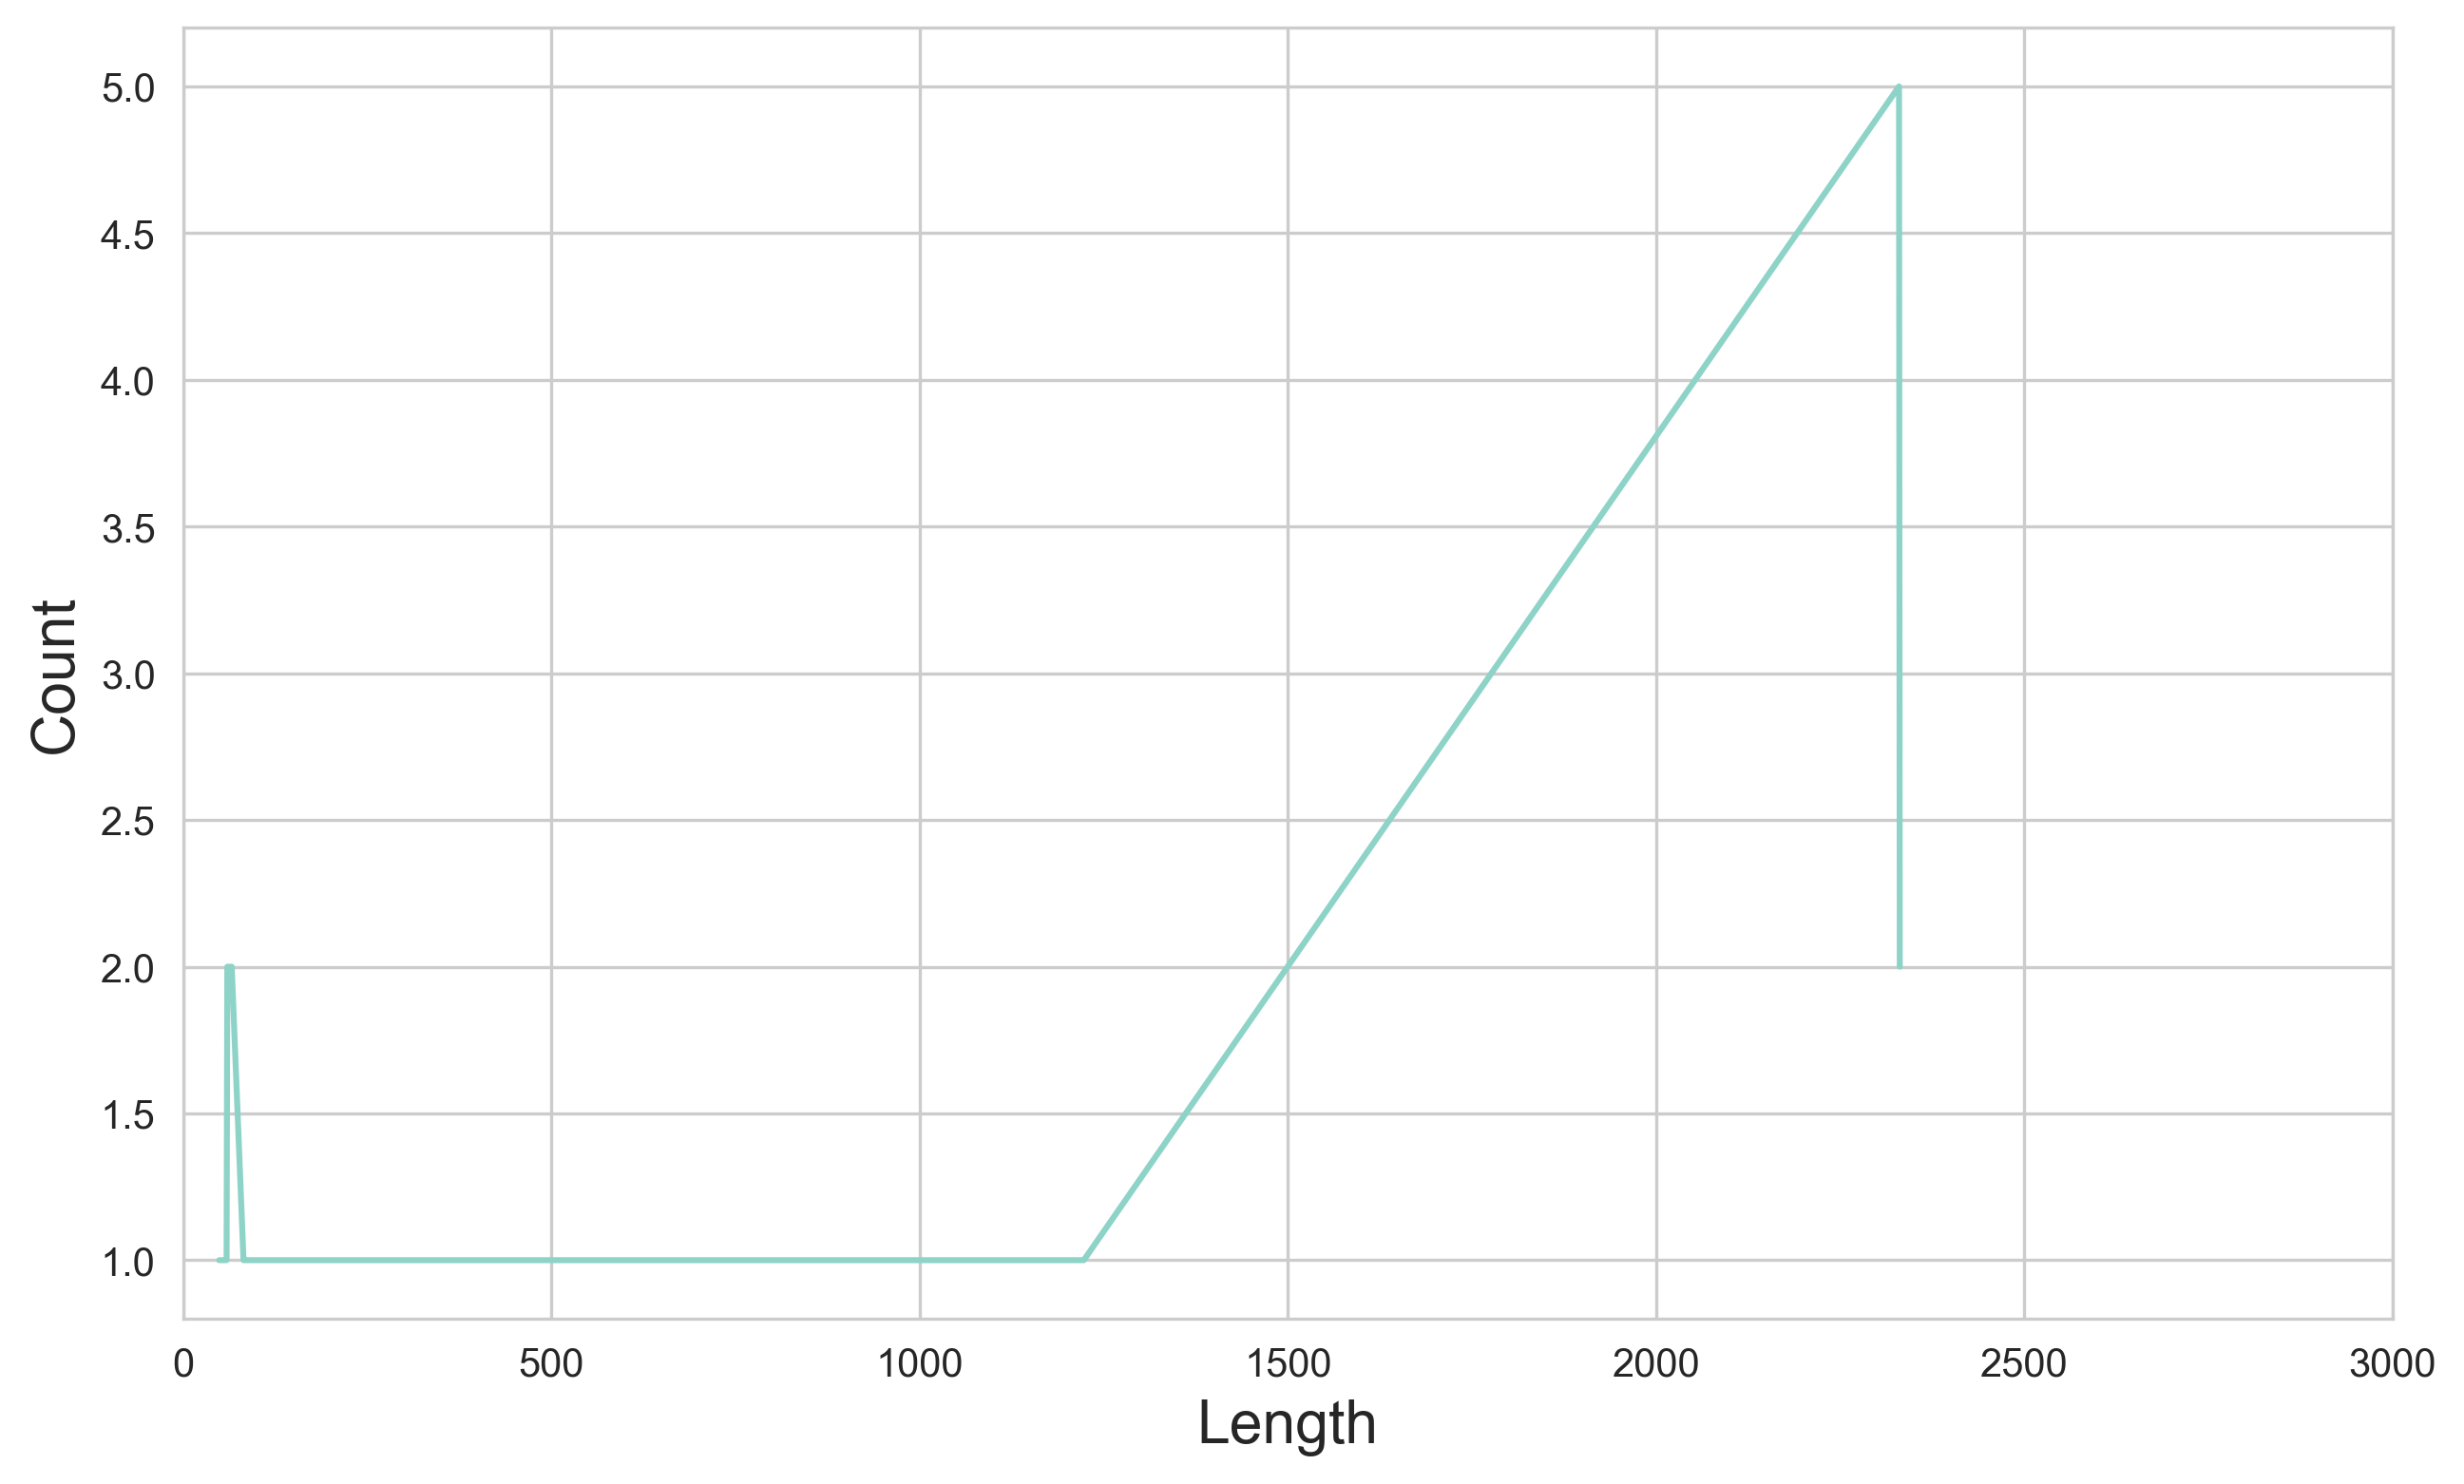

In [20]:
# Dfam ref sequence 
dfamSeqLenList = [ i.endIdx - i.startIdx for i in dfamPositionList ]
getSequenceLengthAnalsis(dfamSeqLenList)

In [24]:
BS2df = pd.DataFrame(columns=['startIdx','endIdx','length','seq'])
for i in dfamPositionList:
    BS2df = BS2df.append({'startIdx': i.startIdx,'endIdx': i.endIdx ,'length':i.endIdx-i.startIdx,'seq': parseFastaA[0][i.startIdx: i.endIdx]}, ignore_index=True)
BS2df.to_csv('./Evaluation/Source/chrX_BS2_ref.csv', index=False)

In [73]:
# Repeat sequence
# repeatFragmentLenList = [ i.endIdx - i.startIdx for i in repeatPositionList ]
# getSequenceLengthAnalsis(repeatFragmentLenList)

In [31]:
# alignments = pairwise2.align.globalxx("ACCGT", "ACG")
# alignments[0].score / 

3.0

In [32]:
def consensusSeqSimilarity(consensusSeq, seqDf):
    seqSimilarityList = []
    for targetSeq in seqDf:
        alignments = pairwise2.align.globalxx(consensusSeq, targetSeq)
        targetLength = len(targetSeq)
        similarityPercentage = round(alignments[0].score / targetLength, 2)
        seqSimilarityList.append(similarityPercentage)
    return seqSimilarityList

# repeatMatchIdxList = []
# for idx, value in enumerate(RDrepeatMatchList):
#     if value == True:
#         repeatMatchIdxList.append(idx)
# repeatBasePositionList = [repeatPositionList[i] for i in repeatMatchIdxList]
# repeatSeqDf = pd.DataFrame(columns=['startIdx','endIdx', 'length', 'seq'])
# for i in repeatBasePositionList:
#     repeatSeqDf = repeatSeqDf.append({'startIdx':i.startIdx ,'endIdx': i.endIdx, 'length': (i.endIdx- i.startIdx), 'seq': str(parseFastaA[0][i.startIdx:i.endIdx])}, ignore_index=True)
conParseFasta = parseFasta(
    "DF0001549_BS2",
    "./Evaluation/Source/DF0001549_BS2.fa",
    "*",
    matchMode=False,
)
consensusSeq = conParseFasta[0].upper()
repeatDf = pd.read_csv('./Evaluation/Source/chrX_BS2_ref.csv')
seqDf = repeatDf["seq"]
seqSimilarityList = consensusSeqSimilarity(consensusSeq, seqDf)
pd.Series(seqSimilarityList).describe()

...start parsing DF0001549_BS2 fasta file ...
...cost0.0017971992492675781 sec to parse fasta file ...


count    31.000000
mean      0.970645
std       0.055253
min       0.870000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
dtype: float64

(0.0, 1.1)

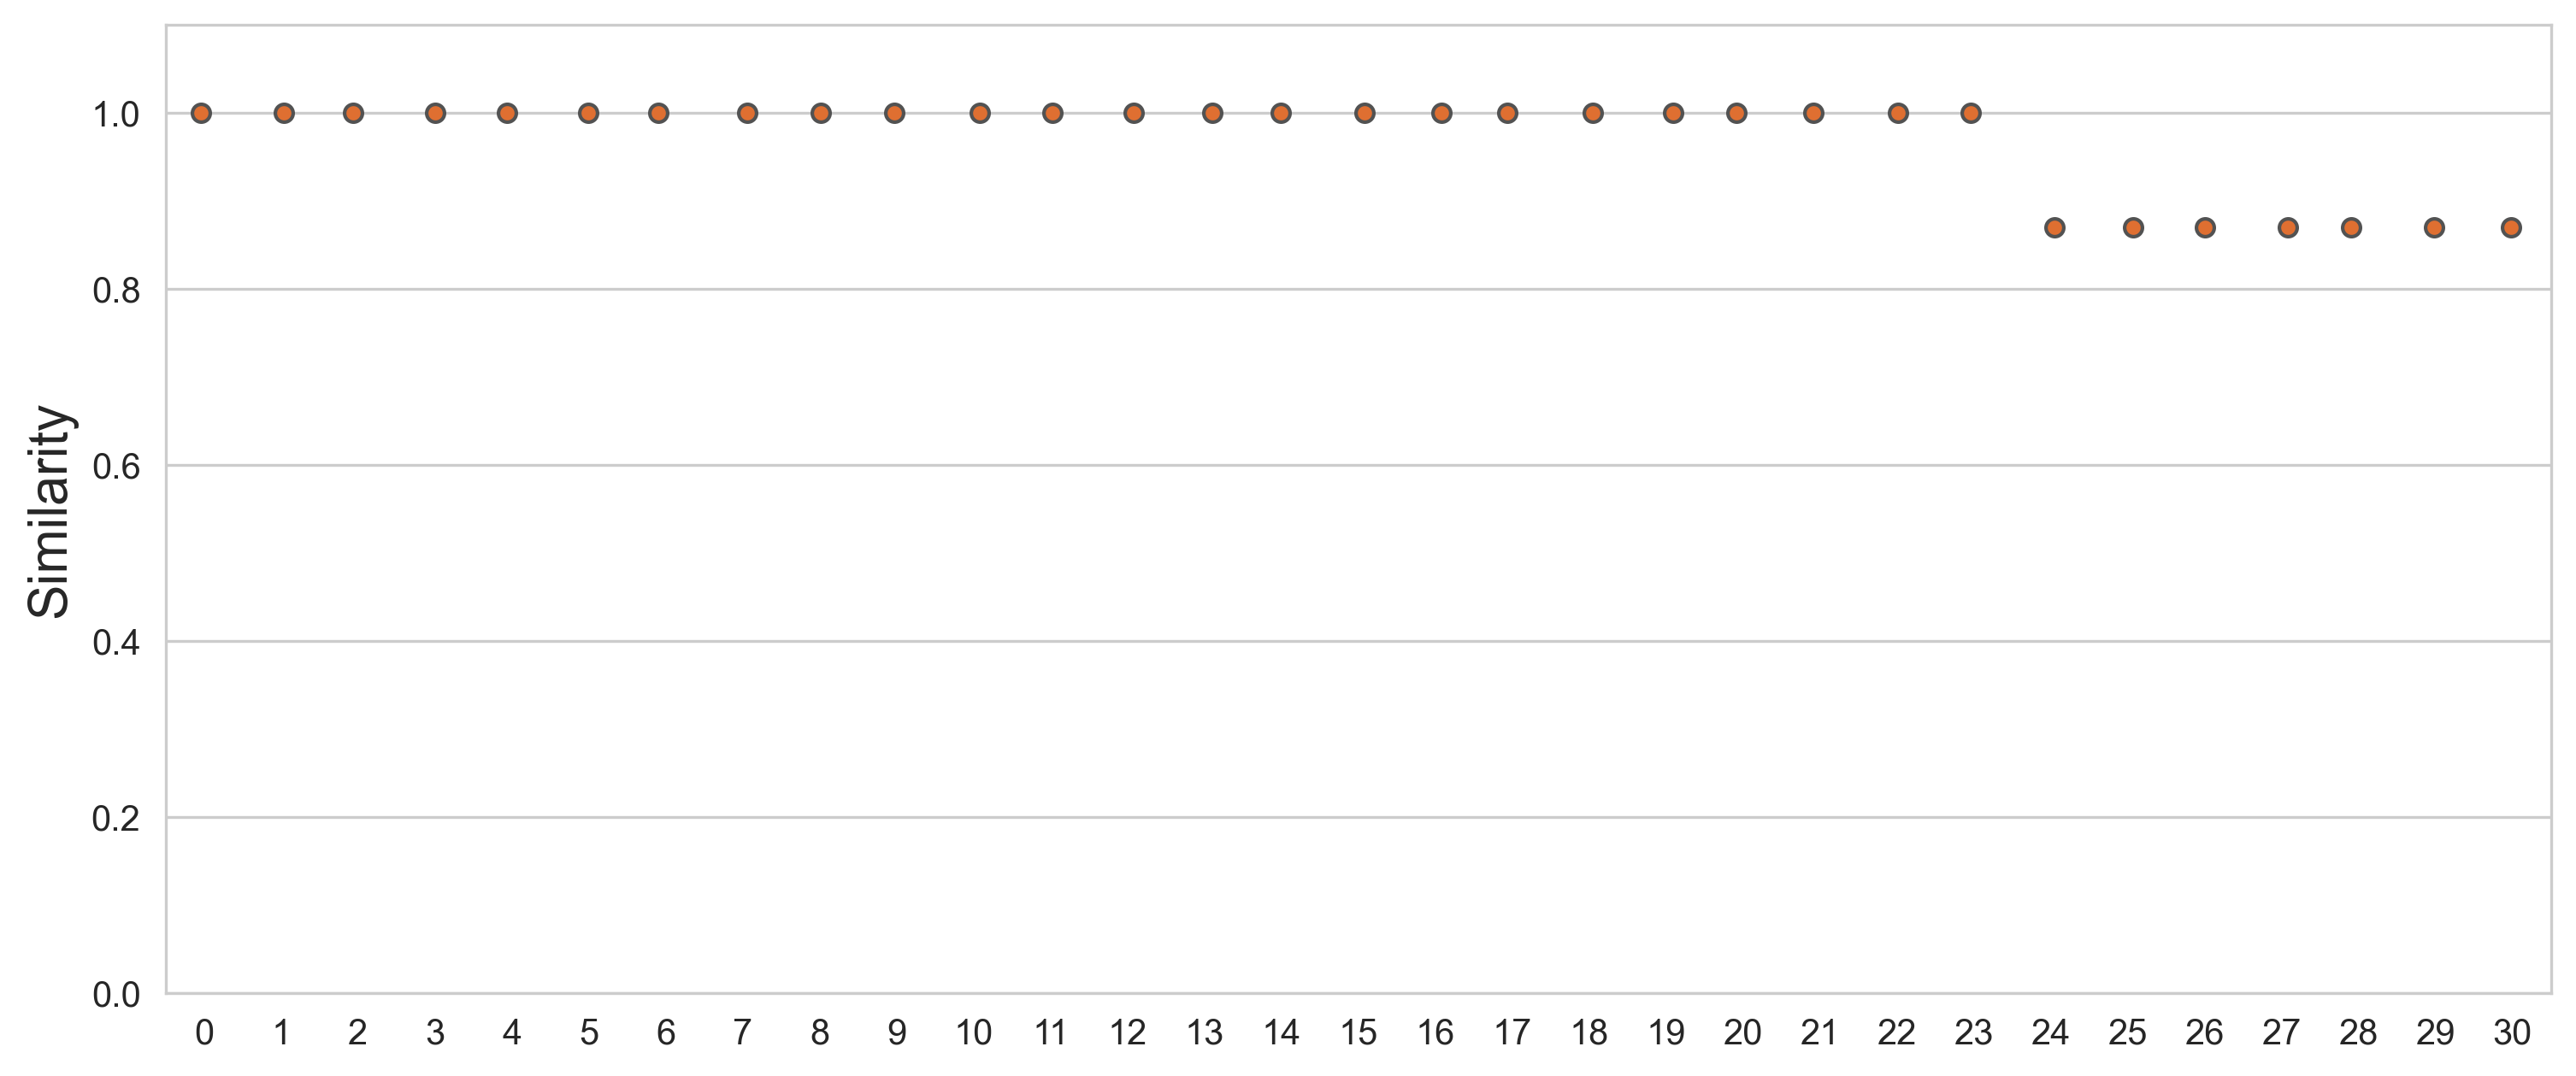

In [33]:
xData = [*range(len(seqSimilarityList))]
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)
sns.set_style("whitegrid")
sns.stripplot(x=xData, y=seqSimilarityList, linewidth=1.0, color=colorA)
ax.set_ylabel("Similarity", size=15)
ax.set_ylim(0,1.1)

In [75]:
# # Test cutter A
# repeatPositionListA = seqA.getRepeatPositionList()
# dfamA = DfamEvaluation(repeatPositionListA)
# repeatPositionLookupDicA = dfamA.positionBucketClassifier()
# dfamPositionListA = dfamA.getDfamPositionList()
# dfamPositionLookupDicA = dfamA.positionBucketClassifier()
# DRrepeatMatchListA, DRmatchedFamilyAccListA, DRmatchedFamilyNameListA = dfamA.checkDfamMatchWithRepeat()

In [76]:
# totalLen = len(DRrepeatMatchListA)
# matchLenA = len(list(filter(lambda x: x, DRrepeatMatchListA)))
# ratio = matchLenA / totalLen
# print(f"matchCount:{matchLenA}\tdfamCount:{totalLen}\tRatio:{ratio}")

In [77]:
# # Test cutter B
# repeatPositionListB = seqB.getRepeatPositionList()
# dfamB = DfamEvaluation(repeatPositionListB)
# repeatPositionLookupDicB = dfamB.positionBucketClassifier()
# dfamPositionListB = dfamB.getDfamPositionList()
# dfamPositionLookupDicB = dfamB.positionBucketClassifier()
# DRrepeatMatchListB, DRmatchedFamilyAccListB, DRmatchedFamilyNameListB = dfamB.checkDfamMatchWithRepeat()

In [78]:
# totalLen = len(DRrepeatMatchListB)
# matchLenB = len(list(filter(lambda x: x, DRrepeatMatchListB)))
# ratio = matchLenB / totalLen
# print(f"matchCount:{matchLenB}\tdfamCount:{totalLen}\tRatio:{ratio}")

In [79]:
# total = 597
# middle = matchLenA+matchLenB - total
# plt.figure(linewidth=10, facecolor="white", dpi=1200)
# # plt.figure(linewidth=10, facecolor="white")
# v = venn2(subsets = (matchLenA-middle, matchLenB-middle, middle), set_labels = (f'CutterA - {cutterA} ', f'CutterB - {cutterB}'), set_colors=(colorA, colorB))
# plt.show()
